In [48]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
from openai import OpenAI as oai
import ast
from openai import AzureOpenAI
import os
from langchain.llms import OpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import SequentialChain
from langchain.chains import LLMChain
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain_openai import AzureChatOpenAI
import matplotlib.pyplot as plt
import pickle
import re
from collections import defaultdict

In [49]:
# Class to initialize Azure model
class mOpenAI:
    def __init__(self):
        self.client = AzureOpenAI(
            api_key="Add your API key",
            api_version="Add your API version",
            azure_endpoint="Add your API end-point"
        )
        self.deployment_name = 'Add your deployment name'

### Set configuration here


In [50]:
# Configuration
api_to_use = "Azure" # Options: "Azure" and "OpenAI"
prompting_method = "direct" # Options: "direct" and "chain_of_thought"
scale_to_generate = "gad" # Options "phq" or "gad"
use_demographics = False # Adds demographic information to the prompt
re_run = False
save_results = False
scale_given = "gad"
scale_generated = "phq"
file_name_to_save_load = f"gpt-4-{scale_generated}-given-{scale_given}"

In [51]:
drive_base = "../"

In [52]:
# reading phq9 and gad7 data
surveys = pd.read_csv(drive_base + "DepreST-CAT-main/surveysDepreST-CAT.csv")

In [53]:
surveys.head()

,id,appVersion,PHQ - Q1,PHQ - Q2,PHQ - Q3,PHQ - Q4,PHQ - Q5,PHQ - Q6,PHQ - Q7,PHQ - Q8,...,GAD - Q7,GAD - Total,Gender,Age,StudentStatus,PriorDepressionTreatment,Remote,COVID,Group,Timestamp
0,1MZ0A5PA6,stereotype threat,2,1,2,3,2,1,3,0,...,1,12,Woman,24-39,No & I am not a student,Yes,Yes - Full Time,No\/I don't know,White\/Caucasian,"""2021-03-21 00:29:43.016253"""
1,E7EEQIEOV,control,1,0,1,1,0,1,1,0,...,1,5,Woman,40-55,No & I am not a student,Prefer not to answer,No - Not At All,Yes,White\/Caucasian,"""2021-03-20 00:16:25.943488"""
2,IHNGBZ4G4,control,1,1,2,3,3,2,2,1,...,1,7,Woman,40-55,No & I am not a student,Yes,No - Not At All,No\/I don't know,White\/Caucasian,"""2021-03-21 22:33:41.260353"""
3,R8CI0EGMO,stereotype threat,1,2,3,2,2,3,3,0,...,0,11,Woman,40-55,No & I am not a student,Yes,Yes - Full Time,No\/I don't know,White\/Caucasian,"""2021-03-20 05:03:37.222712"""
4,FWJ1GB40T,control,2,2,2,3,1,2,3,1,...,1,19,Other,18-23,Yes & I am a undergrad student,Yes,No - Not At All,No\/I don't know,White\/Caucasian,"""2021-03-20 11:47:32.838462"""


In [54]:
phq_columns = [c for c in surveys.columns if c.startswith("PHQ")][:-1]
gad_columns = [c for c in surveys.columns if c.startswith("GAD")][:-1]

In [55]:
# Saving responses and demographics in a dictionary
responses_dict = defaultdict(lambda: {})
demographics={}
for i, row in surveys.iterrows():
    participant_id = row["id"]
    phq_responses = [int(row[c]) for c in phq_columns]
    gad_responses = [int(row[c]) for c in gad_columns]
    responses_dict[participant_id]['phq'] = phq_responses
    responses_dict[participant_id]['gad'] = gad_responses
    demographics[participant_id] = {"age": row["Age"], "gender": row["Gender"], "group": row["Group"], "prior-treatment": row["PriorDepressionTreatment"]}


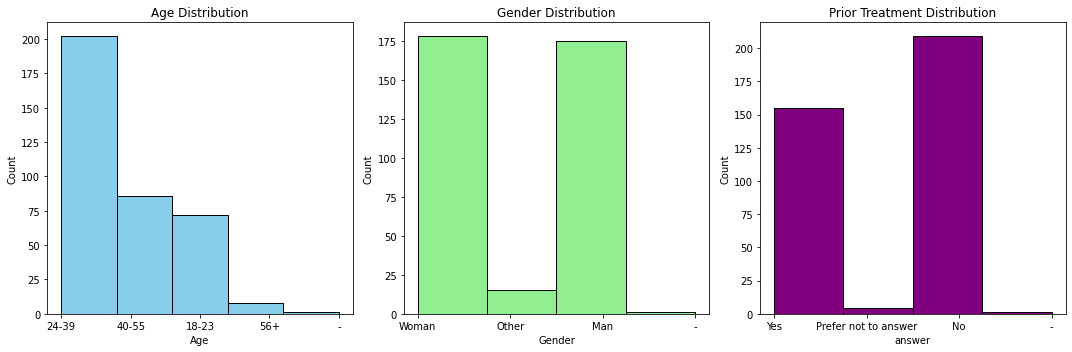

In [56]:
# Demographics information of participants
ages = [demographics[key]['age'] for key in demographics]
genders = [demographics[key]['gender'] for key in demographics]
groups = [demographics[key]['group'] for key in demographics]
prior_treatment = [demographics[key]['prior-treatment'] for key in demographics]

# Plot histograms for age, gender, and group
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(ages, bins=len(set(ages)), color='skyblue', edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
plt.hist(genders, bins=4, color='lightgreen', edgecolor='black')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
plt.hist(prior_treatment, bins=len(set(prior_treatment)), color='purple', edgecolor='black')
plt.title('Prior Treatment Distribution')
plt.xlabel('answer')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [57]:
phq_scores = [sum(responses_dict[p]['phq']) for p in responses_dict]
gad_scores = [sum(responses_dict[p]['gad']) for p in responses_dict]
scores_dict = {'gad': gad_scores, 'phq': phq_scores}

In [58]:
gad_scale = {
    "Not at all": 0,
    "Several days": 1,
    "More than half the days": 2,
    "Nearly every day": 3
}

phq_scale = {
    "Not at all": 0,
    "Several days": 1,
    "More than half the days": 2,
    "Nearly every day": 3
}

In [59]:
scale_max = {'phq':27, 'gad':21}

In [60]:
phq_dict = {
    "questions": [
        "Little interest or pleasure in doing things",
        "Feeling down, depressed, or hopeless",
        "Trouble falling or staying asleep, or sleeping too much",
        "Feeling tired or having little energy",
        "Poor appetite or overeating",
        "Feeling bad about yourself or that you are a failure or have let yourself or your family down",
        "Trouble concentrating on things, such as reading the newspaper or watching television",
        "Moving or speaking so slowly that other people could have noticed. Or the opposite being so fidgety or restless that you have been moving around a lot more than usual",
        "Thoughts that you would be better off dead, or of hurting yourself"
    ],
    "asking_prompt": "score the given PHQ scale questions as the person 'X' would have from 0 to 3 (inclusive). 0 denotes 'Not at all', 1 denotes 'Several days', 2 denotes 'more than half days', 3 denotes 'nearly everyday'. Here are the statements, score them one by one:",
    "asking_prompt_demo": "score the given PHQ scale questions as the person 'X' would have from 0 to 3 (inclusive). 0 denotes 'Not at all', 1 denotes 'Several days', 2 denotes 'more than half days', 3 denotes 'nearly everyday'. Make sure to use demographic information too. Here are the statements, score them one by one:",

    "asking_prompt_chain": "score the given PHQ scale questions as the person 'X' would have from 0 to 3 (inclusive). 0 denotes 'Not at all', 1 denotes 'Several days', 2 denotes 'more than half days', 3 denotes 'nearly everyday'. Here are the statements, think step by step and score one by one",
    "providing_prompt": "Suppose person 'X' answered these PHQ scale questions from 0 to 3 where 0 denotes 'Not at all', 1 denotes 'Several days', 2 denotes 'more than half days', 3 denotes 'nearly everyday'. Here are the statements:"
}

In [61]:
gad_dict = {
    "questions": [
    "Feeling nervous, anxious, or on edge",
    "Not being able to stop or control worrying",
    "Worrying too much about different things",
    "Trouble relaxing",
    "Being so restless that it is hard to sit still",
    "Becoming easily annoyed or irritable",
    "Feeling afraid, as if something awful might happen"
],
    "asking_prompt": "score the given GAD scale questions as the person 'X' would have from 0 to 3 (inclusive). 0 denotes 'Not at all', 1 denotes 'Several days', 2 denotes 'more than half days', 3 denotes 'nearly everyday'. Here are the statements, score them one by one",
    "asking_prompt_demo": "score the given GAD scale questions as the person 'X' would have from 0 to 3 (inclusive). 0 denotes 'Not at all', 1 denotes 'Several days', 2 denotes 'more than half days', 3 denotes 'nearly everyday'. Make sure to use demographic information too. Here are the statements, score them one by one",

    "asking_prompt_chain": "score the given GAD scale questions as the person 'X' would have from 0 to 3 (inclusive). 0 denotes 'Not at all', 1 denotes 'Several days', 2 denotes 'more than half days', 3 denotes 'nearly everyday'. Here are the statements, think step by step and score one by one",
    "providing_prompt": "Suppose person 'X' answered these GAD scale questions from 0 to 3 where 0 denotes 'Not at all', 1 denotes 'Several days', 2 denotes 'more than half days', 3 denotes 'nearly everyday'. Here are the statements:"
}

In [62]:
prompt_dict = {}
prompt_dict["gad"] = gad_dict
prompt_dict["phq"] = phq_dict

In [63]:
# extracts list out of GPT response
def extract_list(text):
    try:
        pattern = r'\[(.*?)\]'
        match = re.search(pattern, text)
        if match:
            return [int(x) for x in match.group(1).split(',')]
        else:
            return None
    except AttributeError:
        return None

In [64]:
# Generates prompt with demographic information
def prompt_generator_with_demographics(demographics, single_chain = True):
    prompt = ''
    prompt_chain = ''

    pysc_demo = "Based on these responses understand the psychological state of person 'X'"
    age = demographics["age"]
    gender = demographics["gender"]
    treatment = demographics["prior-treatment"]
    demo_text = f"Person X belongs to following demographics: \nAge: {age}, \nGender: {gender}, \nPrior Depression Treatment: {treatment} \n\n"

    given = prompt_dict[scale_given]
    generate = prompt_dict[scale_to_generate]
    scores = scores_dict[scale_given]

    prompt += demo_text
    prompt += given["providing_prompt"] + "\n\n"

    questions = ""
    for q, s in zip(given["questions"], scores):
        questions += q + "\n"
        questions += str(s) + "\n"

    questions += "\n"
    prompt += questions


    if(single_chain):
        len_of_scores = len(generate['questions'])
        prompt = prompt + pysd_demo
        prompt += " and "
        prompt += generate["asking_prompt_demo"]

        prompt += "\n\n"

        for q in generate["questions"]:
            prompt += q + "\n"
        prompt = prompt + f"Just return a list of {len_of_scores} scores you provided in format [scores] and nothing else"
    else:
        prompt = prompt + pysc_demo
        prompt += " and "
        prompt += generate["asking_prompt_chain"]
        prompt += "\n\n"

        for q in generate["questions"]:
            prompt += q + "\n"
        len_of_scores = len(generate['questions'])
        prompt_chain = prompt_chain + f"Now return the {len_of_scores} scores in a list [scores]"
    return prompt, prompt_chain

In [65]:
def prompt_generator(single_chain = True):
    prompt = ''
    prompt_chain = ''
    pysc = "Based on these responses understand the psychological state of person 'X'"

    given = prompt_dict[scale_given]
    generate = prompt_dict[scale_to_generate]
    scores = scores_dict[scale_given]
    prompt = given["providing_prompt"] + "\n\n"

    questions = ""
    for q, s in zip(given["questions"], scores):
        questions += q + "\n"
        questions += str(s) + "\n"

    questions += "\n"
    prompt += questions


    if(single_chain):
        len_of_scores = len(generate['questions'])
        prompt = prompt + pysc
        prompt += " and "
        prompt += generate["asking_prompt"]

        prompt += "\n\n"

        for q in generate["questions"]:
            prompt += q + "\n"
        prompt = prompt + f"Just return a list of {len_of_scores} scores you provided in format [scores] and nothing else"
    else:
        prompt = prompt + pysc
        prompt += " and "
        prompt += generate["asking_prompt_chain"]
        prompt += "\n\n"

        for q in generate["questions"]:
            prompt += q + "\n"

        len_of_scores = len(generate['questions'])


        prompt_chain = prompt_chain + f"Now return the {len_of_scores} scores in a list [scores]"
    return prompt, prompt_chain

In [66]:
chat_gpt_scores_dict = {}

In [67]:
sample_prompt = True
def run_GPT_models():
    print(f"generating for scale {scale_to_generate}")
    if(prompting_method == "direct"):
        if (api_to_use == "Azure"):
            print("using Azure API")
            client = mOpenAI().client
            deployment_name = mOpenAI().deployment_name
        else:
            print("Directly using OpenAI API")
            client = oai()
            deployment_name = "gpt-4-turbo-preview"
    else:
        if (api_to_use == "Azure"):
            print("using Azure API")
            llm = AzureChatOpenAI(deployment_name="NUHAI-GPT4", model_name="gpt-4-turbo-preview", api_version="2023-12-01-preview")
        else:
            print("Directly using OpenAI API")
            llm = ChatOpenAI(model_name="gpt-4-turbo-preview")

    for key in responses_dict:
        if (key not in chat_gpt_scores_dict.keys() or chat_gpt_scores_dict[key] == []):
            scores = []
            phq_responses = responses_dict[key][0]
            gad_responses = responses_dict[key][1]

            if(use_demographics):
                print("Using Demographics Information\n")
                prompt1, prompt2 = prompt_generator_with_demographics(demographics[key], prompting_method == "direct")
            else:
                prompt1, prompt2 = prompt_generator(prompting_method == "direct")

            if sample_prompt:
              print(prompt1)
              print("***********")
              print(prompt2)
              sample_prompt = False

            if(prompting_method == "direct"):
                response = client.chat.completions.create(
                    model=deployment_name, messages=[{"role": "user", "content": prompt1},])

                scores = response.choices[0].message.content

            else:
                prompt1 = PromptTemplate(template=prompt1, input_variables=[])
                prompt2 = PromptTemplate(template="agent's scores: \n\n {psyc} \n\n" + prompt2, input_variables =[])

                chain1 = LLMChain(llm=llm, prompt= prompt1, output_key="psyc")
                chain2 = LLMChain(llm=llm, prompt= prompt2, output_key="scores")


                overall_chain = SequentialChain(
                    chains=[chain1, chain2],
                    input_variables = [],
                    output_variables=["psyc", "scores"],
                    verbose=True)

                response = overall_chain({})
                scores = response["scores"]


            scores = extract_list(scores)

            expected_size = -1
            if scale_to_generate == "gad":
                expected_size = 7
            else:
                expected_size = 9

            if(scores == None or len(scores) != expected_size):
                scores = []

            chat_gpt_scores_dict[key] = scores

            print("running for", key)
            print("gad: ")
            print(gad_responses)
            print("phq:")
            print(phq_responses)
            print(f"Predicted {scale_to_generate}: ")
            print(scores)
            if(scale_to_generate == "gad"):
              print("differences", sum(scores) - sum(gad_responses))
            if(scale_to_generate == "phq"):
              print("differences", sum(scores) - sum(phq_responses))



In [68]:
if(re_run):
    run_GPT_models(scale_to_generate)
    if save_results:
        with open(drive_base + f"outputs/{file_name_to_save_load}", 'wb') as f:
            pickle.dump(chat_gpt_scores_dict, f)
        with open(drive_base + f"outputs/responses_gad_phq", 'wb') as f:
            pickle.dump(dict(responses_dict), f)
else:
    with open(drive_base + f"outputs/{file_name_to_save_load}", 'rb') as f:
        chat_gpt_scores_dict = pickle.load(f)



In [69]:
def get_scores(responses_dict, chat_gpt_scores_dict):
    scale_given_scores = []
    scale_generated_scores = []
    chatgpt_scores = []
    for key in responses_dict:
        scale_given_responses = responses_dict[key][scale_given]
        scale_generated_responses = responses_dict[key][scale_generated]
        chatgpt_responses = chat_gpt_scores_dict[key]
        assert(len(scale_generated_responses) == len(chatgpt_responses))

        scale_given_score = sum(scale_given_responses)
        scale_generated_score = sum(scale_generated_responses)
        chatgpt_score = sum(chatgpt_responses)
        scale_given_scores.append(scale_given_score)
        scale_generated_scores.append(scale_generated_score)
        chatgpt_scores.append(chatgpt_score)
    return scale_given_scores, scale_generated_scores, chatgpt_scores

In [70]:
def calc_metrics(responses_dict, chat_gpt_scores_dict, metric="spearman"):
    if metric == "spearman":
        function = spearmanr
    else:
        function = "pearson"

    scale_given_scores = []
    scale_generated_scores = []
    chatgpt_scores = []
    itemized_error = []
    keys = []
    for key in responses_dict:
        scale_given_responses = responses_dict[key][scale_given]
        scale_generated_responses = responses_dict[key][scale_generated]
        chatgpt_responses = chat_gpt_scores_dict[key]

        assert len(scale_generated_responses) == len(chatgpt_responses)
        itemized_error.append(sum(np.abs(np.array(scale_generated_responses) - np.array(chatgpt_responses))))

        scale_given_score = sum(scale_given_responses)
        scale_generated_score = sum(scale_generated_responses)
        chatgpt_score = sum(chatgpt_responses)
        scale_given_scores.append(scale_given_score)
        scale_generated_scores.append(scale_generated_score)
        chatgpt_scores.append(chatgpt_score)
        keys.append(key[0])

    corr_coeff1, p_value1 = function(scale_given_scores, scale_generated_scores)
    print(f"{metric} correlation coefficient {scale_generated} and {scale_given} (real):", corr_coeff1)
    print("p-value:", p_value1)

    corr_coeff2, p_value2 = function(chatgpt_scores, scale_given_scores)
    print(f"{metric} correlation coefficient {scale_given} (real) and {scale_generated}(chat-gpt)", corr_coeff2)
    print("p-value:", p_value2)

    corr_coeff3, p_value3 = function(chatgpt_scores, scale_generated_scores)
    print(f"{metric} correlation coefficient {scale_generated} and {scale_generated}(chatgpt)", corr_coeff3)
    print("p-value:", p_value3)

    error = sum(np.abs(np.array(scale_generated_scores) - np.array(chatgpt_scores))) / len(scale_generated_scores)
    error = error / scale_max[scale_generated]
    print(f"aggregated error is {error}")

    itemized_error = sum(itemized_error) / (scale_max[scale_generated] * len(itemized_error))
    print(f"itemized error is {itemized_error}")

    print("\n\n")

    return corr_coeff1, p_value1, corr_coeff2, p_value2, corr_coeff3, p_value3, error, itemized_error


In [71]:
results = calc_metrics(responses_dict, chat_gpt_scores_dict)

spearman correlation coefficient phq and gad (real): 0.8498628079536316
p-value: 3.937441364115329e-104
spearman correlation coefficient gad (real) and phq(chat-gpt) 0.9540144664619057
p-value: 4.1293567494474376e-194
spearman correlation coefficient phq and phq(chatgpt) 0.8074650943099971
p-value: 3.9028383669575024e-86
aggregated error is 0.13650506875439125
itemized error is 0.22101776573321288



